In [1]:
#Import deps 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
# ... 

### Introduction
What makes the perfect bottle of wine? 

Wine is a major industry, with sales projected to steadily grow beyond $40 billion USD by 2029. [Source](https://www.statista.com/statistics/922403/global-wine-market-size/)

For the longest time, the secrets of the timeless art of winemaking were restricted to the intuitions and implicit knowledge of the vintners themselves. Today it is possible to apply the techniques of machine learning to analyze the chemical components of wine to determine how they influence the quality rating of the wine.

This study conducts machine learning analysis on the chemical constitutents of 6497 different wines (1599 reds and 4898 white ) to identify the predictive relationships between these features and wine quality. 

The purpose of this study is to show how machine learning can be applied to commercial pursuits and potentially improve sales and production quality of products. 


In [2]:
# Import Data 
#Drop wine type from the get-go. May change later
all_wine_raw_df = pd.read_csv('./Wine_data_both.csv')
red_wine_df = pd.read_csv('./Wine_data_red.csv')
white_wine_df = pd.read_csv('./Wine_data_white.csv')


In [3]:
# Inspect raw data 
print('All wine data types', all_wine_raw_df.info())
print('all wine value counts', all_wine_raw_df['quality'].value_counts())
# Try separating red and white or wine types 
display(all_wine_raw_df)
# Manually encode wine type (Wine) to. 
all_wine_raw_df['Wine'] = all_wine_raw_df['Wine'].map({'White': 0, 'Red': 1})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  Wine                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
All wine data types None
all wine value counts quality
6    283

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Wine
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,White
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,White
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,White
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,White
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,Red
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,Red
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,Red
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,Red


### Data Preparation, Encoding & Feature Engineering

Since our EDA discovered that our data had several outliers, we chose to remove these from the dataset. 
We decided to use the IsolationForest ML model to detect outliers rather than zscore or IQR

In [4]:
# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=400, contamination=.03, random_state=42)

# Fit the model
iso_forest.fit(all_wine_raw_df)

# Predict anomalies
outliers = iso_forest.predict(all_wine_raw_df)
# -1 for outliers, 1 for inliers

all_wine_raw_df['Outlier'] = outliers

# Filter out outliers

all_wine_raw_df = all_wine_raw_df[all_wine_raw_df['Outlier'] == 1].drop(columns=['Outlier'])


In [5]:
# Upgrade all 8s to become 9s and 3s to become 4s (binning)
all_wine_raw_df.loc[all_wine_raw_df['quality'] == 8, 'quality'] = 9
all_wine_raw_df.loc[all_wine_raw_df['quality'] == 3, 'quality'] = 4

all_9s = all_wine_raw_df[all_wine_raw_df['quality'] == 9]
all_4s = all_wine_raw_df[all_wine_raw_df['quality'] == 4]
all_6s = all_wine_raw_df[all_wine_raw_df['quality'] == 6]


mean_all_9s = all_9s.mean()
mean_all_4s = all_4s.mean()
mean_all_6s = all_6s.mean()
# Compare the means (difference between highest and lowest rated wines)
mean_difference_high_to_low = mean_all_9s - mean_all_4s
mean_difference_high_to_average = mean_all_9s - mean_all_6s

# Display the results
print("Mean values for highest rated wines (quality == 9):")
print(mean_all_9s)
print("\nMean values for lowest rated wines (quality == 3):")
print(mean_all_4s)
print("\nMean values for average rated wines (quality == 6):")
print(mean_all_6s)
print("\nDifference in mean values between highest and lowest:")
print(mean_difference_high_to_low)
print("\nDifference in mean values between highest and average:")
print(mean_difference_high_to_average)


Mean values for highest rated wines (quality == 9):
fixed acidity             6.798387
volatile acidity          0.283952
citric acid               0.333333
residual sugar            5.536559
chlorides                 0.039672
free sulfur dioxide      34.655914
total sulfur dioxide    120.177419
density                   0.992419
pH                        3.219086
sulphates                 0.492849
alcohol                  11.645699
quality                   9.000000
Wine                      0.048387
dtype: float64

Mean values for lowest rated wines (quality == 3):
fixed acidity             7.284259
volatile acidity          0.428542
citric acid               0.278102
residual sugar            4.281481
chlorides                 0.054176
free sulfur dioxide      21.347222
total sulfur dioxide    107.509259
density                   0.994687
pH                        3.221898
sulphates                 0.485926
alcohol                  10.176620
quality                   4.000000
Wine  

One of the biggest challenges we faced was an significantly imbalanced data set. The minority classes, with quality =(3, 4, 9) were underepresented by several orders of magnitude compared to the majority class with quality=9 just having 5 samples and quality=6, the most frequent approx 3,000. 

Initial experiments were unable to come up with a model with sufficient sensitivity to predict minority classes with this sort of discrepancy. So we had to get clever. 

The cell below takes the mean values of the minority classes and uses it as the "typical value" for that class. Since 9 is so under-represented, it likely wouldn't be realistic to generalize from its average with only n=5 data points using SMOTE. So the decision was made to merge quality=8 into it. And do do the same for 3s and 4's. We argue this loss in target resolution is made up for improved model performance. 

We then use the **generate_synthetic_samples** function to inject a number of statistically similar values into the sample set. 

It achieves this by using a multivariate normal distribution, which describes a set of random variables that may be correlated with each other, where each variable follows a normal distribution. 

In order realistially simulate the possibility of covariance between the different values of a single data entry, we pass the covariance matrix of the dataframe into np.random.multivariate_normal. It then multiplies this by a noise scale, ensuring that there the results resemble the average in the dataset without overly imitating it. 

In [6]:
def generate_synthetic_samples(mean_values, n_samples, noise_scale=0.03):
    synthetic_samples = np.random.multivariate_normal(
        mean=mean_values, 
        cov=all_wine_raw_df.cov() * noise_scale, 
        size=n_samples
    )
    return pd.DataFrame(synthetic_samples, columns=mean_values.index)
# Grab all the minority classes in the data and take their means, inject the magic # 30 
synthetic_9s = generate_synthetic_samples(mean_all_9s, 30)

synthetic_4s = generate_synthetic_samples(mean_all_4s, 30)
# Add the target column to the synthetic samples
synthetic_9s['quality'] = 9
synthetic_4s['quality'] = 4
# Combine synthetic samples with the original data
synthetic_data = pd.concat([synthetic_9s, synthetic_4s])
combined_data = pd.concat([all_wine_raw_df, synthetic_data])

Below we repeat the steps performed a few cells above to verify that the values of the updated data still resemble what they were originally.  

In [7]:
all_9s = combined_data[combined_data['quality'] == 9]
all_4s = combined_data[combined_data['quality'] == 4]
all_6s = combined_data[combined_data['quality'] == 6]


synth_mean_all_9s = all_9s.mean()
synth_mean_all_4s = all_4s.mean()
# Compare the means (difference between highest and lowest rated wines)
synth_mean_difference_high_to_low = synth_mean_all_9s - synth_mean_all_4s
synth_mean_difference_high_to_average = mean_all_9s - mean_all_6s

# Display the results
print("Mean values for highest rated wines (quality == 9):")
print(synth_mean_all_9s)
print("\nMean values for lowest rated wines (quality == 3):")
print("\nMean values for average rated wines (quality == 6):")
print(mean_all_6s)
print("\nDifference in mean values between highest and lowest:")
print(synth_mean_difference_high_to_low)
print("\nDifference in mean values between highest and average:")
print(synth_mean_difference_high_to_average)


Mean values for highest rated wines (quality == 9):
fixed acidity             6.802533
volatile acidity          0.283987
citric acid               0.333679
residual sugar            5.555464
chlorides                 0.039677
free sulfur dioxide      34.614187
total sulfur dioxide    120.186236
density                   0.992422
pH                        3.218001
sulphates                 0.492313
alcohol                  11.643747
quality                   9.000000
Wine                      0.048094
dtype: float64

Mean values for lowest rated wines (quality == 3):

Mean values for average rated wines (quality == 6):
fixed acidity             7.138989
volatile acidity          0.310215
citric acid               0.321948
residual sugar            5.561908
chlorides                 0.052754
free sulfur dioxide      31.445122
total sulfur dioxide    116.501435
density                   0.994494
pH                        3.216786
sulphates                 0.526564
alcohol                

Later, we apply cross validation techniques to verify the integrity of this synthetic data. 

In [8]:
# Manually encode the wine type, 0 is White, Red is 1
# Gretel.ai ---> Generating synthetic data 

# We dropped wine type for the time being
#combined_data['wine type'] = all_wine_raw_df['Wine'].map({'White': 0, 'Red': 1})

# Define the feature and target variables
# Note: We learned what features to drop through EDA and in the optimizations performed below. 
X = combined_data.drop(columns=[ 'Wine', 'alcohol', 'quality', 'citric acid', 'chlorides', 'density' ], axis=1)
y =  combined_data['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

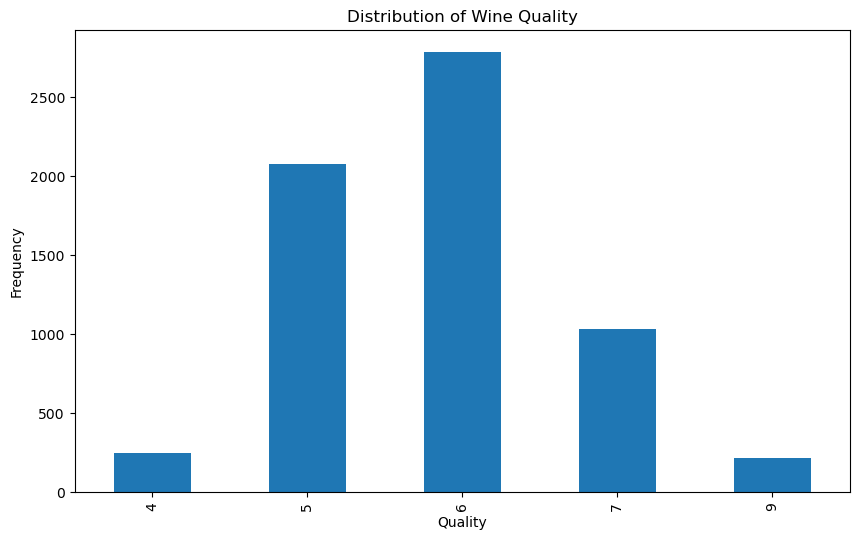

In [9]:
# Determine if data is balanced or imbalanced
plt.figure(figsize=(10, 6))
y.value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality')
plt.show()

# Clustering or feature engineering by clumping 3s/4s/5s/ low  6s/ medium/ 7,8,9 high quality 

Since our data is still very imbalanced, we want apply a few techniques to compensate for it. One method is to calculate class weights, which will help inform the model to learn more from the minority classes. 

In [10]:
# Since our data is very imbalanced, lets try calculating class weights 
unique_classes = np.array([4, 5, 6, 7, 9])
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(unique_classes, class_weights)}

print(f'Class weights: {class_weight_dict}')

Class weights: {4: 5.166497461928934, 5: 0.6123947051744886, 6: 0.45641255605381165, 7: 1.230713422007255, 9: 5.883236994219653}


Next we wanted to look into feature selection. We learned that the most significant features are 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', and 'alcohol'. 

Using VIF (variance inflation factor) we also learned which features contributed most to multicolinearity.

In [11]:
# Feature Selection and regularization : What features can we drop? 
# Here we learned that density and alcohol could be dropped

# Initialize Lasso regression
lasso = Lasso(alpha=0.1)  
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error: {mse}')

# Check selected features
selected_features = X_train.columns[lasso.coef_ != 0]
print(f'Selected Features: {selected_features}')


# Calculate variance inflation factor for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Based on these results, we could consider dropping at least pH and density, and possibly also alcohol 

# Compute the correlation matrix
correlation_matrix = X.corr()

# Display the correlation matrix
print(correlation_matrix)


Mean Squared Error: 0.907990466658343
Selected Features: Index(['fixed acidity', 'free sulfur dioxide', 'total sulfur dioxide'], dtype='object')
                feature        VIF
0         fixed acidity  35.375998
1      volatile acidity   7.098100
2        residual sugar   3.218172
3   free sulfur dioxide   9.008878
4  total sulfur dioxide  13.383761
5                    pH  58.162530
6             sulphates  20.053600
                      fixed acidity  volatile acidity  residual sugar  \
fixed acidity              1.000000          0.229857       -0.121832   
volatile acidity           0.229857          1.000000       -0.205742   
residual sugar            -0.121832         -0.205742        1.000000   
free sulfur dioxide       -0.282564         -0.356371        0.418870   
total sulfur dioxide      -0.319924         -0.414228        0.499692   
pH                        -0.227241          0.252718       -0.273684   
sulphates                  0.266787          0.203544       -0.1

### Model Development

For our model we decided to use the versatile RandomizedTreeClassifier algorithm, which, after some experimentation with other algos proved to consistently give the best results.  

First, we did some hyperparameter tuning to try to find the best model. 

In [12]:
# Define a simpler parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
}


In [13]:
# Define the actual model code using what we've learned and search for a best model 

# Initialize RFC
rfc = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

# Perform the random search on the training data
random_search.fit(X_train, y_train)

# Get the best model
best_rfc = random_search.best_estimator_

# Predict on the scaled test data
y_pred_rfc = best_rfc.predict(X_test)

# Evaluate the best model
print("Best RFC Classification Report:")
print(classification_report(y_test, y_pred_rfc))
print("Best RFC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfc))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END criterion=gini, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, ma

In [14]:
print(best_rfc)
classifier = RandomForestClassifier(class_weight=class_weight_dict, criterion='log_loss', max_depth=30, max_features='log2', n_estimators=500, random_state=42)
classifier.fit(X=X_train, y=y_train)
y_pred_best = classifier.predict(X_test)

print("Best RFC Classification Report:")
print(classification_report(y_test, y_pred_best))
print("Best RFC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

RandomForestClassifier(class_weight={4: 5.166497461928934,
                                     5: 0.6123947051744886,
                                     6: 0.45641255605381165,
                                     7: 1.230713422007255,
                                     9: 5.883236994219653},
                       max_depth=20, max_features='log2', n_estimators=300,
                       random_state=42)
Best RFC Classification Report:
              precision    recall  f1-score   support

           4       0.87      0.27      0.41        49
           5       0.66      0.69      0.67       416
           6       0.63      0.77      0.69       558
           7       0.82      0.49      0.62       207
           9       0.88      0.35      0.50        43

    accuracy                           0.66      1273
   macro avg       0.77      0.51      0.58      1273
weighted avg       0.69      0.66      0.66      1273

Best RFC Confusion Matrix:
[[ 13  22  13   1   0]
 [  1 287 126 

Our model performs reasonably well for precision, however struggles with recall especially for the minority classes. 

#### Cross-Validation

Here we cross-validate the model using StratifiedKFold. We find that our cross validation scores are decent but not great.

In [15]:

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation when trained against synthetic data
cv_scores_synthetic_data = cross_val_score(best_rfc, X, y, cv=kfold, scoring='f1_weighted')

# Output the cross-validation scores against the da
print(f'Cross-Validation Score Against Synthetic Data: {cv_scores_synthetic_data}')
print(f'Mean Cross-Validation Score Against Synthetic Data: {np.mean(cv_scores_synthetic_data)}')


Cross-Validation Score Against Synthetic Data: [0.6624762  0.68472731 0.65806995 0.66301959 0.65778309]
Mean Cross-Validation Score Against Synthetic Data: 0.6652152305168124


#### A/B Testing

As a control experiment, we run the same model against the raw data. The model is generall less capable across the board, but most notably, is entirely unable to detect the minority classes (quality= 3 and quality=9)

In [16]:
raw_data = pd.read_csv('./Wine_data_both.csv') 
X_raw = raw_data.drop(columns=['quality', 'Wine'])
y_raw = raw_data['quality']
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)
raw_classifier = RandomForestClassifier( class_weight=class_weight_dict, criterion='log_loss', max_depth=30, max_features='log2', n_estimators=500, random_state=42)
raw_classifier.fit(X=X_train_raw, y=y_train_raw)
y_pred_best_raw = raw_classifier.predict(X_test_raw)

print("Raw Data RFC Classification Report:")
print(classification_report(y_test_raw, y_pred_best_raw))
print("Raw Data Confusion Matrix:")
print(confusion_matrix(y_test_raw, y_pred_best_raw))

Raw Data RFC Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.78      0.16      0.27        43
           5       0.71      0.75      0.73       428
           6       0.65      0.78      0.71       567
           7       0.75      0.52      0.61       216
           8       0.86      0.31      0.45        39
           9       0.00      0.00      0.00         1

    accuracy                           0.69      1300
   macro avg       0.53      0.36      0.40      1300
weighted avg       0.69      0.69      0.67      1300

Raw Data Confusion Matrix:
[[  0   0   2   4   0   0   0]
 [  0   7  21  15   0   0   0]
 [  0   1 320 107   0   0   0]
 [  0   1  98 440  27   1   0]
 [  0   0   9  94 112   1   0]
 [  0   0   0  16  11  12   0]
 [  0   0   0   1   0   0   0]]


/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We also run our model against the both red and white wine types.

In [17]:
reds = combined_data[combined_data['Wine'] == 1]
whites = combined_data[combined_data['Wine']== 0]

X_red = reds.drop(columns=[ 'Wine','alcohol', 'quality', 'citric acid', 'chlorides', 'density' ], axis=1)
y_red = reds['quality']
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red, test_size=0.2, random_state=42, stratify=y_red)

red_classifier = RandomForestClassifier( class_weight=class_weight_dict, criterion='log_loss', max_depth=30, max_features='log2', n_estimators=500, random_state=42)
red_classifier.fit(X=X_train_red, y=y_train_red)
y_pred_best_red = red_classifier.predict(X_test_red)

print("Red Wine Data RFC Classification Report:")
print(classification_report(y_test_red, y_pred_best_red))
print("Red Wine Data Confusion Matrix:")
print(confusion_matrix(y_test_red, y_pred_best_red))

Red Wine Data RFC Classification Report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         8
           5       0.77      0.80      0.78       127
           6       0.71      0.78      0.74       119
           7       0.79      0.59      0.68        32
           9       1.00      0.50      0.67         2

    accuracy                           0.74       288
   macro avg       0.65      0.53      0.57       288
weighted avg       0.73      0.74      0.73       288

Red Wine Data Confusion Matrix:
[[  0   7   1   0   0]
 [  0 101  26   0   0]
 [  0  22  93   4   0]
 [  0   2  11  19   0]
 [  0   0   0   1   1]]


/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
X_white = whites.drop(columns=[ 'Wine', 'alcohol', 'quality', 'citric acid', 'chlorides', 'density' ], axis=1)
y_white = whites['quality']
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(X_white, y_white, test_size=0.2, random_state=42, stratify=y_white)

white_classifier = RandomForestClassifier( class_weight=class_weight_dict, criterion='log_loss', max_depth=30, max_features='log2', n_estimators=500, random_state=42)
white_classifier.fit(X=X_train_white, y=y_train_white)
y_pred_best_white = white_classifier.predict(X_test_white)

print("White Wine Data RFC Classification Report:")
print(classification_report(y_test_white, y_pred_best_white))
print("White Wine Data Confusion Matrix:")
print(confusion_matrix(y_test_white, y_pred_best_white))


White Wine Data RFC Classification Report:
              precision    recall  f1-score   support

           4       0.69      0.26      0.38        35
           5       0.66      0.64      0.65       289
           6       0.62      0.80      0.70       439
           7       0.75      0.41      0.53       175
           9       0.83      0.43      0.57        35

    accuracy                           0.65       973
   macro avg       0.71      0.51      0.57       973
weighted avg       0.67      0.65      0.64       973

White Wine Data Confusion Matrix:
[[  9  15  11   0   0]
 [  2 186  99   2   0]
 [  2  67 352  18   0]
 [  0  11  89  72   3]
 [  0   1  15   4  15]]


### Evaluation & Interpretation 

Our model preforms less well when ran against white wines. This could be explained by the fact white wines were the smaller data set. 

Here we plot the feature importances of our various model applications.

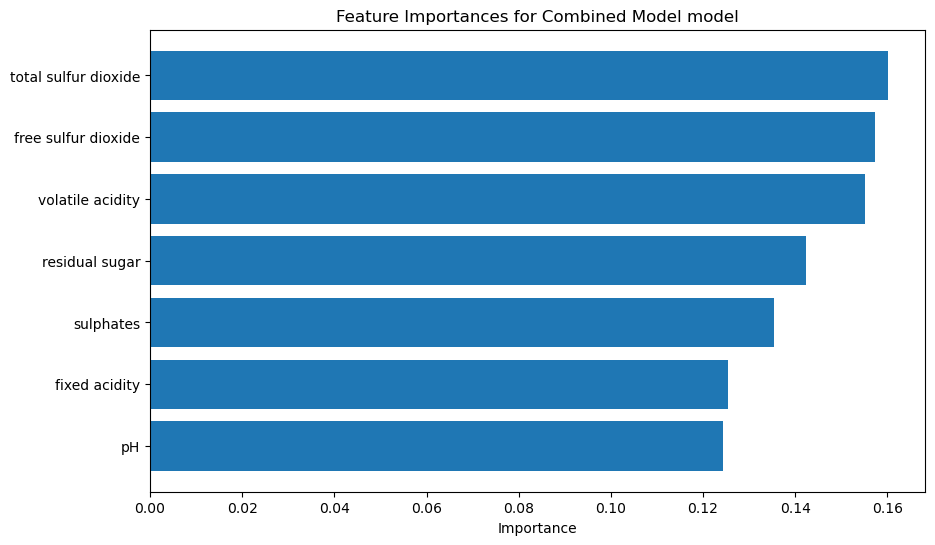

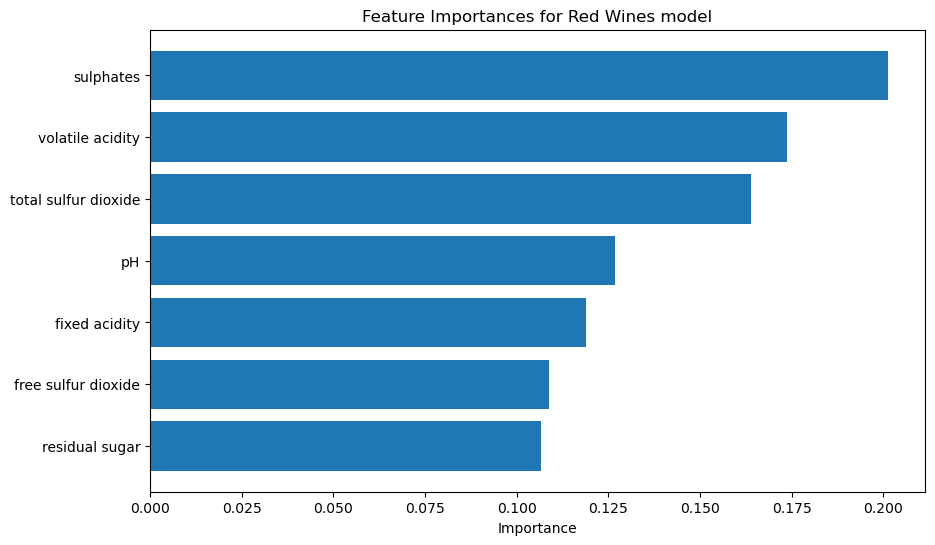

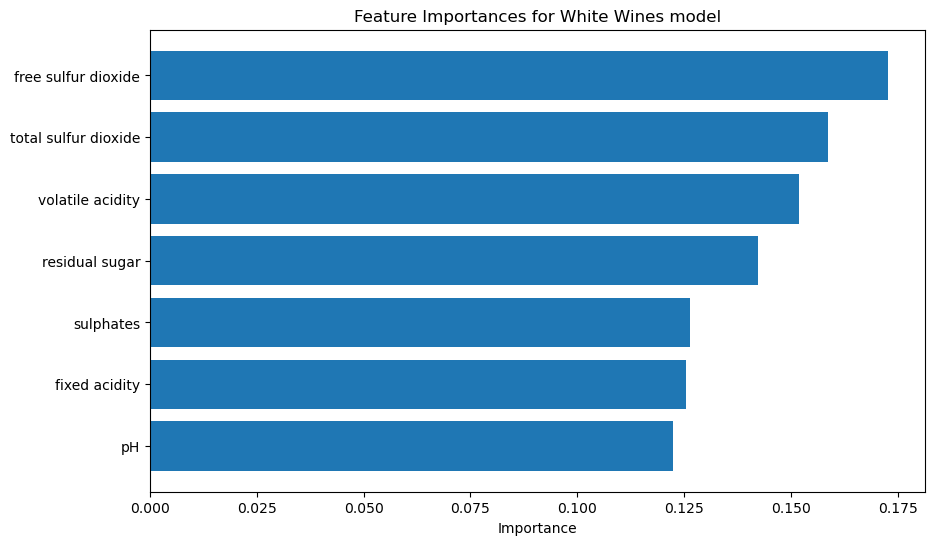

In [19]:
def plot_feature_importances(classifier, X_train, title):
    """
    Plots the feature importances of a given tree-based classifier.

    Parameters:
    classifier: A fitted tree-based classifier with an attribute `feature_importances_`.
    X_train: The training data used to fit the classifier, should be a DataFrame.
    """
    # Extract feature importances
    importances = classifier.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame for the importances
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importances for {title} model')
    plt.gca().invert_yaxis()
    plt.show()

# Feature Importances: 

plot_feature_importances(classifier=classifier, X_train=X_train, title='Combined Model')

plot_feature_importances(classifier=red_classifier, X_train=X_train_red, title='Red Wines')

plot_feature_importances(classifier=white_classifier, X_train=X_train_white, title='White Wines')


For all wines combined total sulfur dioxide , followed by free sulfur dioxide and volatile acidity are the three strongest predictors of wine quality.

For red wines, sulfates, volatile acidity and total sulfur dioxide  are the three most predictive features, followed closely by pH. 

For white wines, free sulfur dioxide, total sulfur dioxide , and volatile acidity are the three most predictive, followed closely by risidual sugar.  